In this notebook, I will use my trained model to generate captions for images in the test dataset.

## Step 1: Get Data Loader for Test Dataset

In [2]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the testing images.
transform_test = transforms.Compose([transforms.Resize(256),
                                     transforms.RandomCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Visualize an example test image

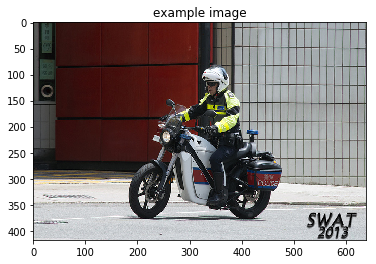

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [17]:
image.shape

torch.Size([1, 3, 224, 224])

## Step 2: Load Trained Models

In [13]:
# define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# saved models to load.
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

# setting the same values
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 91814276.61it/s]


DecoderRNN(
  (embedding): Embedding(7525, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=7525, bias=True)
)

## Step 3: Finish the Sampler

I will use `sample` method in the `DecoderRNN` class in **model.py**.  This method accepts as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It returns as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.

In [24]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 168, 138, 3, 885, 53, 3, 33, 18, 1, 1, 1, 6, 3, 2, 18, 1, 1, 1]


## Step 4: Clean up the Captions

In the code cell below, there is `clean_sentence` function.  It takes a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [25]:
# Complete the function.
def clean_sentence(output):
    sentence = ''
    for word in [data_loader.dataset.vocab.idx2word.get(x) for x in output]:
        
        if word == '<end>':
            break
        if word != '<start>' and word != '.' :
            sentence += ' ' + word
        if word == '.':
            sentence += word 
    sentence = sentence[1].upper() + sentence[2:]
    return sentence

In [28]:
# testing the function
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: A man riding a motorcycle down a street.


## Step 5: Generate Predictions!

Loop over images in the test dataset and print your model's predicted caption.

In [29]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

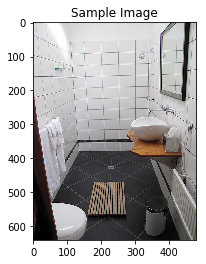

A bathroom with a toilet and a sink


In [30]:
get_prediction()

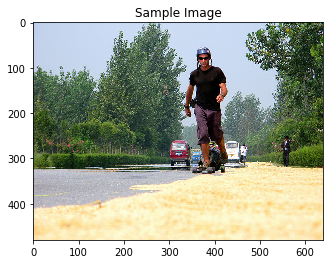

A man riding a skateboard down a street.


In [31]:
get_prediction()

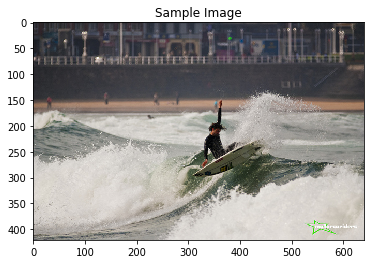

A man riding a surfboard on top of a wave.


In [36]:
get_prediction()

The model performs well! 

That's all folks! 